# Notebook 01: Data Overview & Exploratory Analysis

This notebook begins the analysis by exploring the structure and content of the raw dataset, helping us develop hypotheses and guide data cleaning/modeling later on.

### Objectives of This Notebook:
- Understand the data types, missing values, and distributions
- Explore the class balance of the churn target (`Attrition_Flag`)
- Investigate key categorical variables that may influence churn

### Step 1: Import Libraries
We begin by importing libraries for data manipulation and visualization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load the Dataset
We load the raw dataset and remove any extra whitespace in the column names.

In [2]:
df = pd.read_csv("../data/raw_data.csv")
df.columns = df.columns.str.strip()

### Step 3: Dataset Dimensions & Preview
We look at the number of rows and columns, check the data types, and preview the top records.

In [3]:
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


We have **10,127 rows and 23 columns**, each representing a customer record.  
- No missing values were detected — every feature is fully populated.
- The dataset includes a mix of numerical (e.g., `Customer_Age`, `Credit_Limit`) and categorical variables (e.g., `Gender`, `Education_Level`).
- There are also two long and complex features starting with `Naive_Bayes_Classifier_...` which appear to be automated predictions — we may want to investigate or drop these later as they could bias modeling.

This gives us insight in the dataset’s structure, while also indicating columns that might need extra cleaning or preprocessing before modeling.

### Step 4: Churn Class Balance
Let’s now check if this is a balanced or imbalanced classification problem by generating a quick distribution. This impacts model selection and evaluation later on.

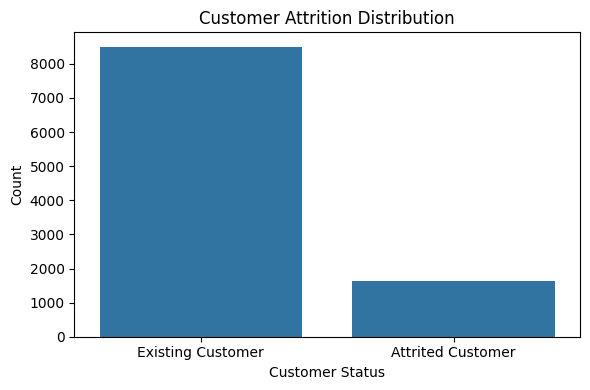

Class Distribution (%):
 Attrition_Flag
Existing Customer    83.93
Attrited Customer    16.07
Name: proportion, dtype: float64


In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Attrition_Flag")
plt.title("Customer Attrition Distribution")
plt.xlabel("Customer Status")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

churn_counts = df['Attrition_Flag'].value_counts(normalize=True) * 100
print("Class Distribution (%):\n", churn_counts.round(2))

 This chart and percentage breakdown show a **high class imbalance**:  
- Existing Customers: **83.93%**
- Attrited Customers: **16.07%**

This imbalance will affect how we train and evaluate models. We'll use stratified sampling, class weighting, and metrics like recall and AUC to manage this effectively.


### Step 5: Categorical Feature Breakdown
We now compare churn rates across categorical variables. This gives us insight about which features might be important predictors.

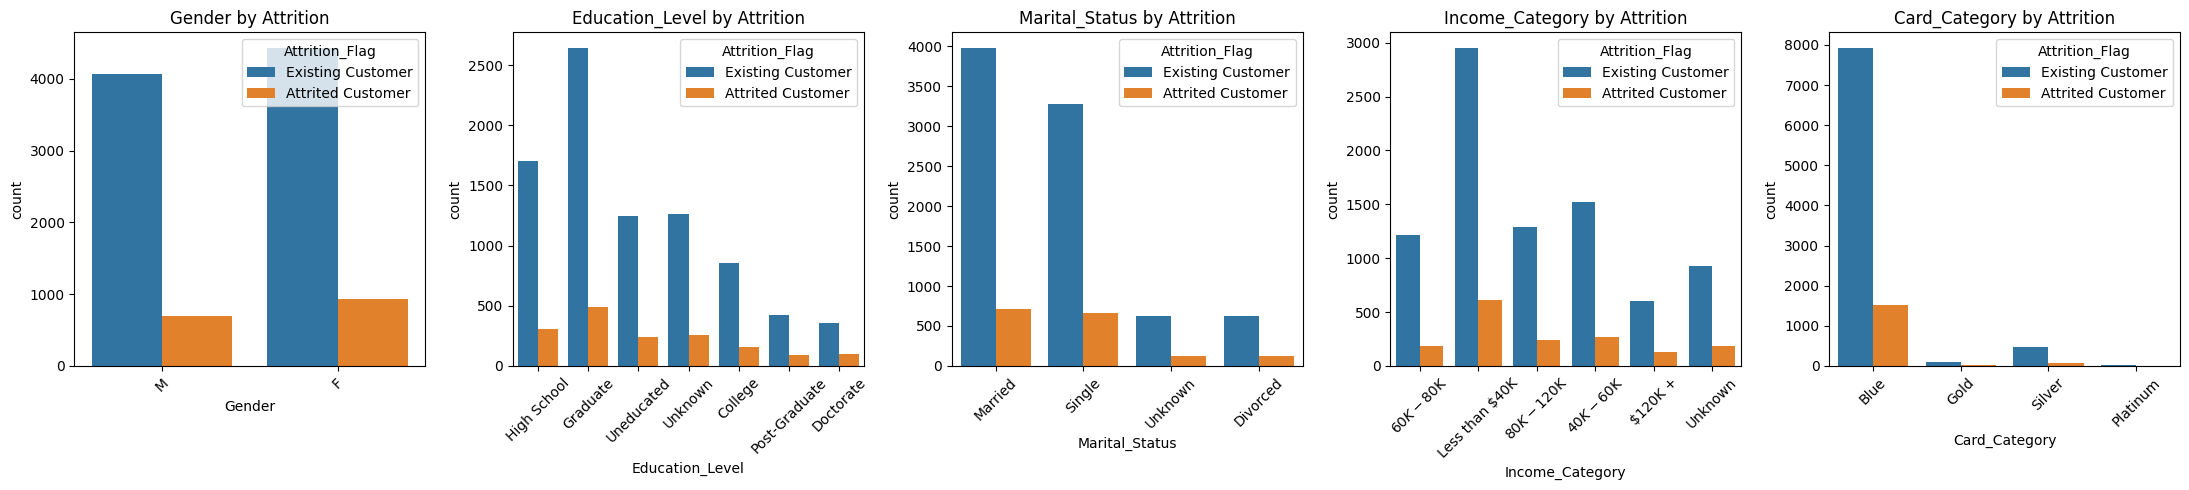

Attrition_Flag,Attrited Customer,Existing Customer
Gender,,
F,17.4%,82.6%
M,14.6%,85.4%
Attrition_Flag,Attrited Customer,Existing Customer
Education_Level,,
College,15.2%,84.8%
Doctorate,21.1%,78.9%
Graduate,15.6%,84.4%
High School,15.2%,84.8%
Post-Graduate,17.8%,82.2%


In [5]:
# Charts
categorical_cols = df.select_dtypes(include="object").columns.tolist()
categorical_cols.remove("Attrition_Flag")

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(22, 5))
axes = axes.flatten()

for i, col in enumerate(categorical_cols[:5]):
    sns.countplot(data=df, x=col, hue="Attrition_Flag", ax=axes[i])
    axes[i].set_title(f"{col} by Attrition")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Tables
from IPython.display import display, HTML

html_blocks = []
for col in categorical_cols[:5]:
    styled_table = (
        df.groupby(col)["Attrition_Flag"]
        .value_counts(normalize=True)
        .unstack()
        .round(3)
        .mul(100)
        .style.set_caption(f"{col} Churn Distribution (%)")
        .format("{:.1f}%")
        .to_html()
    )
    html_blocks.append(f"<div style='flex: 1; padding: 10px'>{styled_table}</div>")

display(HTML(f"<div style='display: flex; flex-wrap: wrap'>{''.join(html_blocks)}</div>"))

Some key patterns emerge when comparing churn percentages across different groups, but it's important to interpret them alongside group sizes shown in the charts:
- **Gender:** Female customers show a slightly higher churn rate **(17.4%)** than male customers **(14.6%)**. However, both genders are similarly represented in the customer base.
- **Education Level:** Customers with Doctorate and Post-Graduate degrees show the highest churn rates (**21.1%** and **17.8%,** respectively), while churn is lower among those with College or High School education. Still,  those highly educated groups represent a small fraction of the total customer base.
- **Marital Status:** Single and Unknown-status customers churn at higher rates **(~17%)**, while Married customers churn less **(15.1%)**. Since Married customers make up the bulk of users, they still account for a large number of churners despite their lower rate.
- **Income Category:** Churn rates are slightly elevated in the lowest **(<$40K)** and highest **(>$120K)** income brackets. However, most customers fall between **$40K** and **$80K** — so the largest number of churners still come from the middle-income range.
- **Card Category:** Although Platinum users have the highest churn rate **(25%)**, they are a tiny portion of the total population. Most churners come from the Blue card group, not because of a high rate, but due to sheer volume of users.

These breakdowns provide valuable insight on which groups are more likely to churn, but they should be paired with overall population sizes to prioritize which customer segments will yield the greatest impact in churn reduction efforts.

### Step 6: Numeric Feature Exploration
We now explore some numeric features using KDE plots for readability and insight.

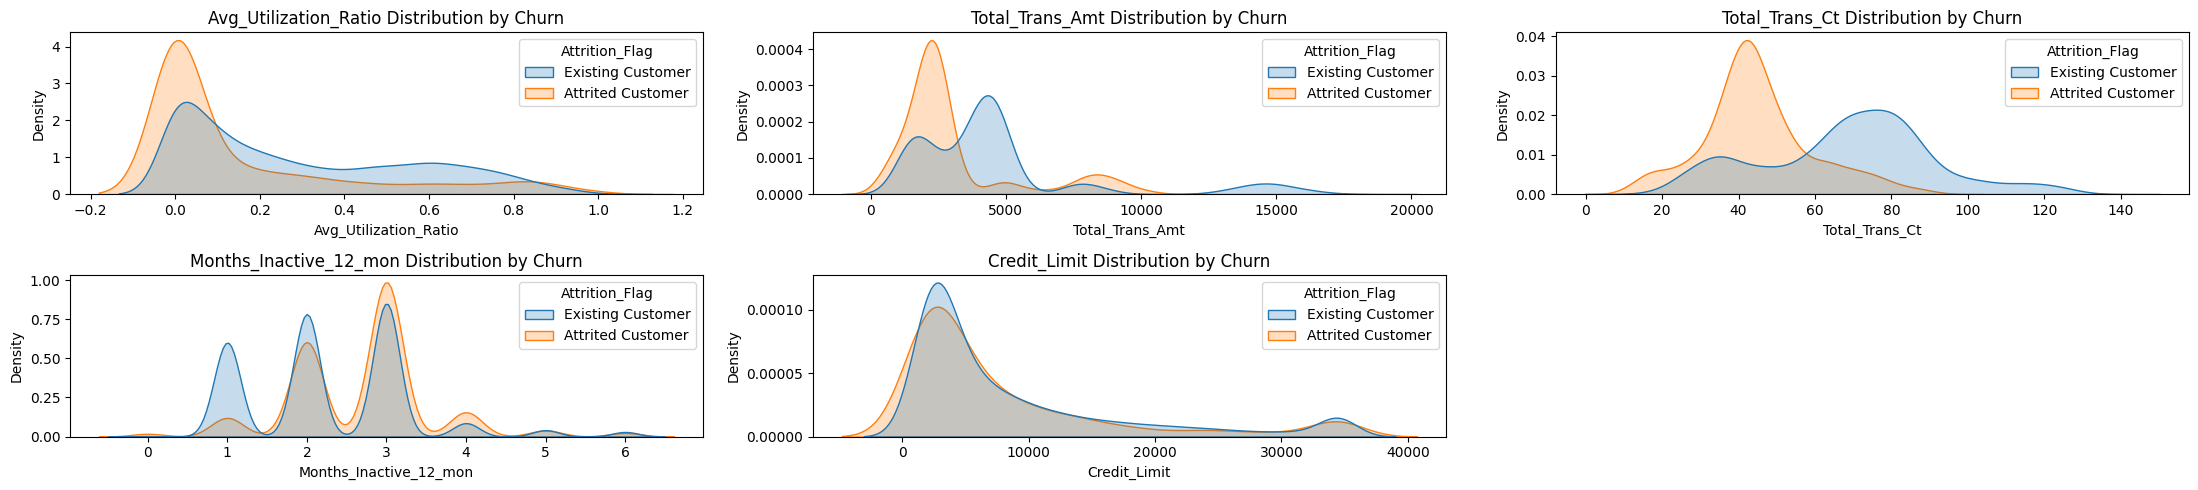

In [6]:
numeric_features = ['Avg_Utilization_Ratio', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Months_Inactive_12_mon', 'Credit_Limit']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 5))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.kdeplot(data=df, x=col, hue="Attrition_Flag", fill=True, common_norm=False, ax=axes[i])
    axes[i].set_title(f"{col} Distribution by Churn")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

fig.delaxes(axes[-1]) 
plt.tight_layout()
plt.show()

The higher the curve, the more common that value is in that group. Overlapping areas show where both churned and retained customers fall within similar ranges.

- **Averge Utilization Ratio**: Churned customers show higher utilization — often using more of their credit, potentially due to financial stress or dissatisfaction.  
- **Total Transaction Amount**: Lower spending is more common among churners, suggesting reduced engagement with their account.  
- **Total Transaction Count**: Churners make significantly fewer transactions, highlighting a strong behavioral signal of disengagement.  
- **Months Inactive**: Churned customers have more inactive months in the past year, further emphasizing lack of use.  
- **Credit Limit**: Churners trend slightly lower in credit limits, though the difference is subtle compared to other features.

These five variables show measurable behavioral and financial trends that can help explain why a customer may be at risk of leaving. 

### Step 7: Summary & Next Steps
With a better understanding of the dataset structure, churn distribution, and key behavioral/demographic patterns, we’ve gained early insights into which factors may influence customer attrition - such as **transaction activity**, **card category**, and **credit usage**.

In Notebook 02, we’ll:
- Clean and transform the dataset for modeling
- Encode categorical features numerically
- Scale numerical variables for algorithm compatibility
- Split the data into training and testing sets